In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [6]:
# df['value'] = holt_winters_imputation_and_expand(
#     df['value'],
#     seasonal_periods=365,
# )
# df.to_csv("../data/imputed_mean.csv")

In [7]:
df = pd.read_csv("../data/imputed_mean.csv")

In [8]:
df_sensors = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

In [9]:

sensor_name = '2'
df = df_sensors[['full_date', sensor_name]].copy()
df.rename(columns={"full_date": "date_time", sensor_name: 'value'}, inplace=True)

In [10]:
df.set_index("date_time", inplace=True)

In [42]:
test_date = "2020-03-01"
test_date = "2020-01-01"
# test_date = "2019-06-01"
# test_date = "2019-01-01" # 57 - 650
test_date = "2018-06-01" # 38 (31) - 436
# test_date = "2018-04-01" # mnogo
# test_date = "2018-01-01" # mnogo
# test_date = "2017-10-01" # mnogo
df_train = df[df.index < test_date].copy()
df_test = df[df.index >= test_date].copy()

df_train.shape, df_test.shape

((436, 1), (860, 1))

In [43]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

from sklearn.metrics import mean_squared_error

def evaluate_on_test(y_hat, y_true):
    return mape(y_true, y_hat), np.sqrt(mean_squared_error(y_hat, y_true))

def plot_preds(y_hat, y_true):
    predictions = pd.DataFrame({
        "Preds": y_hat,
        "Actual": y_true,
        # "train": t['value']
    })
    _, ax = pyplot.subplots()
    ax = predictions.plot(ax=ax)

## data prep

In [44]:
# from statsforecast.models import SeasonalNaive
# from statsforecast.core import StatsForecast
import pandas as pd

# Prepare your data
data = pd.DataFrame({'ds': df_train.index,
                     'y': df_train['value'].values})
data['unique_id'] = "mean"

data['ds'] = pd.to_datetime(data['ds'])

In [45]:
# Prepare your data
data_test = pd.DataFrame({'ds': df_test.index,
                     'y': df_test['value'].values})
data_test['unique_id'] = "mean"

data_test['ds'] = pd.to_datetime(data_test['ds'])

## ML models basics

In [46]:
def train_test_split(series, test_size=0.2):
    """
    Splits the series into train and test sets.

    Parameters:
        series (array-like): The transformed series to split.
        test_size (float): Proportion of the series to include in the test set (default: 0.2).
    
    Returns:
        tuple: (train_series, test_series)
    """
    try:
        n = len(series)
        test_count = int(n * test_size)
        train_series = series[:-test_count]
        test_series = series[-test_count:]
        return train_series, test_series
    except Exception as e:
        warnings.warn(f"Failed to split series into train and test sets: {e}")
        return series, None


14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:56 - cmdstanpy - INFO - Chain [1] done processing


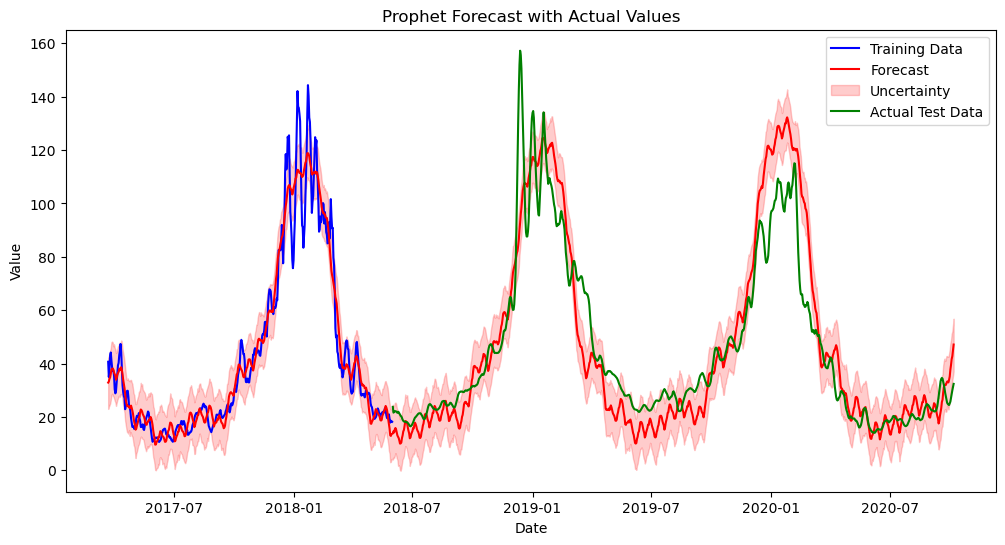

Prophet MAPE: 20.706760877653103%


In [51]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming you have df_train, df_test, data_test, and kazakhstan_holidays defined
kazakhstan_holidays = pd.read_csv('../data/kazakhstan_holidays.csv')

# Load and prepare data for Prophet
df_prophet = df_train.reset_index()
df_prophet.rename(columns={'date_time': 'ds', 'value': 'y'}, inplace=True)

# Explicitly convert 'ds' to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Define the Prophet model
model = Prophet(
    seasonality_mode='multiplicative', 
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays=kazakhstan_holidays
)
# Add custom seasonalities
model.add_seasonality(name='monthly', period=30, fourier_order=15)
model.add_seasonality(name='w', period=7, fourier_order=8)

df_prophet['y'] = df_prophet['y'].rolling(window=7, min_periods=1).mean()
df_test['value'] = df_test['value'].rolling(window=7, min_periods=1).mean()
data_test['y'] = data_test['y'].rolling(window=7, min_periods=1).mean()
# Train model again
model.fit(df_prophet)

# Create future dataframe (next 6 months)
future = model.make_future_dataframe(periods=len(df_test['value']), freq='D')

# Make predictions
forecast = model.predict(future)

# Explicitly convert 'ds' to datetime in forecast
forecast['ds'] = pd.to_datetime(forecast['ds'])


# Plot the forecast AND actual values
fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axes objects

# Plot the training data
ax.plot(df_prophet['ds'], df_prophet['y'], label='Training Data', color='blue')

# Plot the forecast
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

# Plot the uncertainty intervals
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2, label='Uncertainty')

# Ensure data_test has a 'ds' column and convert to datetime
if 'ds' not in data_test.columns:
    data_test['ds'] = data_test.index  # Assuming index is the date
data_test['ds'] = pd.to_datetime(data_test['ds'])

# Plot the actual test data
ax.plot(data_test['ds'], data_test['y'], label='Actual Test Data', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Prophet Forecast with Actual Values')
ax.legend()
plt.show()


# Evaluate Performance (on test data)
test_data_prophet = data_test.copy() # Last 6 months

# Set 'ds' as index for proper alignment
test_data_prophet = test_data_prophet.set_index('ds')

# Set 'ds' as index for proper alignment
forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet.index]

# Compute RMSE and MAPE
rmse_prophet = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_values['yhat']))
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast_values['yhat']) * 100

# print(f"Prophet RMSE: {rmse_prophet}")
print(f"Prophet MAPE: {mape_prophet}%")

In [62]:
ensemble_train_end_date = '2019-04-01'
future_val = future[future['ds'] <= ensemble_train_end_date]
test_data_prophet_val = test_data_prophet[test_data_prophet.index <= ensemble_train_end_date]

In [63]:
from itertools import product

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': np.arange(0.001, 0.03, 0.005),
    'seasonality_prior_scale': np.arange(0.1, 2, 0.2)
}

# Run a grid search
best_mape = float('inf')
best_params = None

for params in product(param_grid['changepoint_prior_scale'], param_grid['seasonality_prior_scale']):
    model = Prophet(changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], 
                    yearly_seasonality=True, 
                    weekly_seasonality=False, 
                    seasonality_mode='additive'
                    )
    model.fit(df_prophet)
    forecast = model.predict(future_val)
    
    # Evaluate
    forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet_val.index]
    mape = mean_absolute_percentage_error(test_data_prophet_val['y'], forecast_values['yhat']) * 100
    
    if mape < best_mape:
        best_mape = mape
        best_params = params

print(f"Best Params: {best_params}, Best MAPE: {best_mape}%")


16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:33:50 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - INFO - Chain [1] start processing
16:33:51 - cmdstanpy - INFO - Chain [1] done processing
16:33:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Params: (0.011, 1.5000000000000004), Best MAPE: 14.60135223059203%


In [68]:
# save model predictions for ensemble. save on full dataset including test
model = Prophet(changepoint_prior_scale=best_params[0], seasonality_prior_scale=best_params[1], 
                    yearly_seasonality=True, 
                    weekly_seasonality=False, 
                    seasonality_mode='additive'
                    )
model.fit(df_prophet)
future = model.make_future_dataframe(periods=len(df_test['value']), freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat']].to_csv('results_of_results/prophet_roll7_2.csv')

16:56:12 - cmdstanpy - INFO - Chain [1] start processing
16:56:12 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
from TimeSeriesImputer import TimeSeriesPreprocessor

In [ ]:
data = df['value'].values.copy()
preprocessor = TimeSeriesPreprocessor(seasonal_period=365)

steps = ['log', 'trend', 'seasonality', 'boxcox', 'standardize']
transformed_series = preprocessor.create_pipeline(data, steps)

In [ ]:
int(len(df['value']) * 0.5)

In [ ]:
df['value'][:int(len(df['value']) * 0.62)]

In [ ]:
distr_model_dict = {}
test_size = 0.37
orig_train, orig_test = train_test_split(transformed_series["original"], test_size)
start_date = df.index[0]

for name, series in transformed_series.items():
    train_series, test_series = train_test_split(transformed_series[name], test_size)

    if len(train_series) == len(orig_train):
        df_prophet_train = pd.DataFrame({'ds': df.index[:len(train_series)], 'y': train_series})
        df_prophet_test = pd.DataFrame({'ds': df.index[len(train_series):], 'y': test_series})
        model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True)
    else:
        df_prophet_train = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=len(train_series), freq='D'), 
                                         'y': train_series})
        df_prophet_test = pd.DataFrame({'ds': pd.date_range(start=df_prophet_train['ds'].iloc[-1] + pd.Timedelta(days=1), 
                                                            periods=len(test_series), freq='D'), 
                                        'y': test_series})
        model = Prophet(seasonality_mode='multiplicative', holidays_mode=False)
    # TODO попробовать разные параметры, авто сезонность, мод аддитив

    model.fit(df_prophet_train)

    future = model.make_future_dataframe(periods=len(test_series), freq='D')
    forecast = model.predict(future)

    # Evaluate Performance (on test data)
    test_data_prophet = df_prophet_test.copy() # Last 6 months
    forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet['ds']]

    rmse_prophet = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_values['yhat']))
    mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast_values['yhat']) * 100

    print(f"{name} Metrics:", rmse_prophet, mape_prophet)

    if mape_prophet < 29:
        distr_model_dict[name] = [train_series, test_series, forecast_values['yhat']]

In [ ]:
from copy import deepcopy

for distr_name, res in distr_model_dict.items():
    distr_preprocessor = deepcopy(preprocessor)
    distr_preprocessor.transforms = distr_name.split('_')

    if "boxcox" in distr_name:
        distr_preprocessor.lambda_param = preprocessor.lambdas[distr_name]

    print(distr_name)

    orig_preds = distr_preprocessor.inverse_transform_predictions(res[-1])

    if len(set(orig_preds)) > 1: 
        print(mean_absolute_percentage_error(orig_test, orig_preds) * 100) 
        plot_preds(orig_preds, orig_test)

## lstm

In [ ]:
# Install TensorFlow if not installed
# !pip install tensorflow numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load and normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare training data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Using 30 days history for each prediction
X, y = create_sequences(df_scaled, seq_length)

# Train-test split
X_train, X_test = X[:-180], X[-180:]
y_train, y_test = y[:-180], y[-180:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
# Build an improved LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),  # Increase neurons
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)  # Try 0.001, 0.0005, 0.0001
model.compile(optimizer=optimizer, loss='mse')
# model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Test Data", color="green")
plt.plot(y_pred_actual, label="LSTM Predictions", color="red", linestyle="dashed")
plt.xlabel("Days")
plt.ylabel("Value")
plt.title("LSTM Model - Forecast vs Actual")
plt.legend()
plt.show()

# Compute RMSE and MAPE
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM MAPE: {mape_lstm}%")
